In [ ]:
!pip install tldextract
!pip install --quiet optuna
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats import randint, uniform
import random
from sklearn.model_selection import KFold, cross_val_score
import re
import tldextract
from urllib.parse import urlparse
from collections import Counter
from scipy.stats import entropy
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score  # For accuracy calculations
from sklearn.exceptions import NotFittedError  # For debugging PCA or scaler errors

import optuna
warnings.filterwarnings("ignore")




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 5.2 MB/s eta 0:00:00


In [ ]:
X = pd.read_csv('/content/phishing_site_urls.csv')
X['URL'].str.strip()
X

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
321925,encyclopedia.com/topic/Waldo_David_Frank.aspx,good
321926,encyclopedia.com/topic/Walloons.aspx,good
321927,encyclopedia.com/topic/Walt_Disney.aspx,good
321928,encyclopedia.com/topic/Walt_Disney_Company.aspx,good


In [ ]:
special_df = pd.DataFrame()
special_chars = set()

def find_special_char(x):
    special_chars_in_x = re.findall(r'[^a-zA-Z0-9]', x)
    special_chars.update(special_chars_in_x)
    return None

X_bad = X[X['Label'] == 'bad']
X_bad['URL'].apply(find_special_char)

special_chars = list(special_chars)
special_chars.remove('.')
special_chars.remove('/')

special_df['Special Character'] = special_chars
special_df['Frequency in bad URLs'] = special_df['Special Character'].apply(
    lambda x: X_bad[X_bad['URL'].str.contains(re.escape(x), regex=True)].shape[0]
)
special_df['Bad probability'] = special_df['Frequency in bad URLs'] / special_df['Special Character'].apply(
    lambda x: X[X['URL'].str.contains(re.escape(x), regex=True)].shape[0]
)
special_df['Score'] = special_df['Bad probability'] * special_df['Frequency in bad URLs'].apply(math.log)
special_df.sort_values(by='Score', ignore_index=True, ascending=False, inplace=True)
special_df

,Special Character,Frequency in bad URLs,Bad probability,Score
0,;,10234,0.926322,8.553163
1,\,3229,0.937028,7.571122
2,@,1773,0.962541,7.200217
3,',3585,0.817187,6.688279
4,&,15362,0.683667,6.590313
...,...,...,...,...
147,ë,1,0.034483,0.000000
148,÷,1,0.038462,0.000000
149,,1,0.058824,0.000000
150,,1,0.050000,0.000000


[';', '\\', '@', "'", '&', '=', '?', ' ', '>', ',']


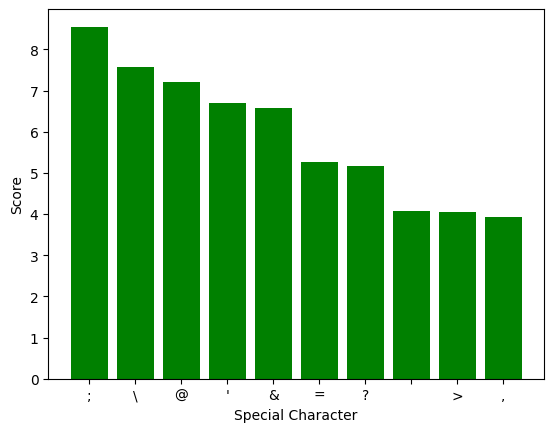

In [ ]:
dangerous_chars = list(special_df['Special Character'].head(10))
print(dangerous_chars)
plt.bar(special_df['Special Character'].head(10), special_df['Score'].head(10), color='green')
plt.xlabel('Special Character')
plt.ylabel('Score')
plt.show()

In [ ]:
TLD_df = pd.DataFrame()
TLD_list = pd.Series(X_bad['URL'].apply(lambda x: tldextract.extract(x).suffix)).unique()

TLD_df['TLD'] = TLD_list
TLD_df['Frequency in bad URLs'] = TLD_df['TLD'].apply(
    lambda x: X_bad[X_bad['URL'].str.contains(re.escape(x), regex=True)].shape[0]
)
TLD_df['Bad probability'] = TLD_df['Frequency in bad URLs'] / TLD_df['TLD'].apply(
    lambda x: X[X['URL'].str.contains(re.escape(x), regex=True)].shape[0]
)
TLD_df['Score'] = TLD_df['Bad probability'] * TLD_df['Frequency in bad URLs'].apply(math.log)
TLD_df.sort_values(by='Score', ignore_index=True, ascending=False, inplace=True)
TLD_df

,TLD,Frequency in bad URLs,Bad probability,Score
0,md,8167,0.903929,8.142465
1,com.br,3781,0.984379,8.109063
2,cm,9922,0.864813,7.958450
3,date,4012,0.902790,7.490492
4,bf,3266,0.904208,7.316239
...,...,...,...,...
536,com.et,1,1.000000,0.000000
537,edu.sg,1,0.100000,0.000000
538,net.pk,1,1.000000,0.000000
539,nhs.uk,1,0.333333,0.000000


['md', 'com.br', 'cm', 'date', 'bf', 'run', 'mx', 'ae', 'mp', 'cc']


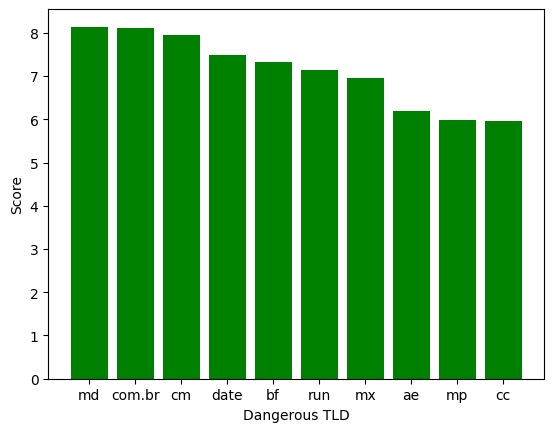

In [ ]:
dangerous_TLDs = list(TLD_df['TLD'].head(10))
print(dangerous_TLDs)
plt.bar(TLD_df['TLD'].head(10), TLD_df['Score'].head(10), color='green')
plt.xlabel('Dangerous TLD')
plt.ylabel('Score')
plt.show()

In [ ]:
X['URL length'] = X['URL'].apply(len)
X['Number of dots'] = X['URL'].apply(lambda x: x.count('.'))
X['Number of slashes'] = X['URL'].apply(lambda x: x.count('/'))
X['Percentage of numerical characters'] = X['URL'].apply(lambda x: sum(c.isdigit() for c in x)) / X['URL length']
X['Dangerous characters'] = X['URL'].apply(lambda x: any(char in x for char in dangerous_chars))
X['Dangerous TLD'] = X['URL'].apply(lambda x: tldextract.extract(x).suffix in dangerous_TLDs)

def urlentropy(url):
    frequencies = Counter(url)
    prob = [frequencies[char] / len(url) for char in url]
    return entropy(prob, base=2)

X['Entropy'] = X['URL'].apply(urlentropy)
ip_pattern = r'[0-9]+(?:\.[0-9]+){3}'
X['IP Address'] = X['URL'].apply(lambda x: bool(re.search(ip_pattern, x)))
X['Domain name length'] = X['URL'].apply(lambda x: len(tldextract.extract(x).domain))

sus_words = ['secure', 'account', 'update', 'login', 'verify', 'signin', 'bank', 'notify', 'click', 'inconvenient']
X['Suspicious keywords'] = X['URL'].apply(lambda x: sum([word in x for word in sus_words]) != 0)
X['Repetitions'] = X['URL'].apply(lambda x: True if re.search(r'(.)\1{2,}', tldextract.extract(x).domain) else False)

def redirection(url):
    pos = url.rfind('//')
    return pos > 7

X['Redirections'] = X['URL'].apply(redirection)
X

,URL,Label,URL length,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,Entropy,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,225,6,10,0.257778,True,False,7.667575,False,6,True,False,False
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,81,5,4,0.012346,True,False,6.190289,False,7,False,False,False
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,177,7,11,0.265537,False,False,7.288285,False,12,True,False,False
3,mail.printakid.com/www.online.americanexpress....,bad,60,6,2,0.000000,False,False,5.786667,False,9,False,False,False
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,116,1,10,0.181034,True,False,6.611978,False,15,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321925,encyclopedia.com/topic/Waldo_David_Frank.aspx,good,45,2,2,0.000000,False,False,5.307909,False,12,False,False,False
321926,encyclopedia.com/topic/Walloons.aspx,good,36,2,2,0.000000,False,False,5.014279,False,12,False,False,False
321927,encyclopedia.com/topic/Walt_Disney.aspx,good,39,2,2,0.000000,False,False,5.187505,False,12,False,False,False
321928,encyclopedia.com/topic/Walt_Disney_Company.aspx,good,47,2,2,0.000000,False,False,5.453338,False,12,False,False,False


In [ ]:
scaler = StandardScaler()
num_columns = ['URL length', 'Number of dots', 'Number of slashes', 'Domain name length', 'Entropy']
X[num_columns] = scaler.fit_transform(X[num_columns])

X['IP Address'] = X['IP Address'].astype(int)
X['Suspicious keywords'] = X['Suspicious keywords'].astype(int)
X['Repetitions'] = X['Repetitions'].astype(int)
X['Redirections'] = X['Redirections'].astype(int)
X['Dangerous characters'] = X['Dangerous characters'].astype(int)
X['Dangerous TLD'] = X['Dangerous TLD'].astype(int)
X['Label'] = (X['Label'] == 'good').astype(int)
X.drop(columns=['URL'], inplace=True)
X

,Label,URL length,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,Entropy,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections
0,0,3.673764,2.081949,4.256530,0.257778,1,0,2.855455,0,-0.754153,1,0,0
1,0,0.559128,1.511378,0.762342,0.012346,1,0,1.056228,0,-0.542810,0,0,0
2,0,2.635552,2.652520,4.838895,0.265537,0,0,2.393508,0,0.513906,1,0,0
3,0,0.104911,2.081949,-0.402388,0.000000,0,0,0.564647,0,-0.120124,0,0,0
4,0,1.316158,-0.770906,4.256530,0.181034,1,0,1.569815,0,1.147935,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321925,1,-0.219531,-0.200335,-0.402388,0.000000,0,0,-0.018446,0,0.513906,0,0,0
321926,1,-0.414195,-0.200335,-0.402388,0.000000,0,0,-0.376065,0,0.513906,0,0,0
321927,1,-0.349307,-0.200335,-0.402388,0.000000,0,0,-0.165089,0,0.513906,0,0,0
321928,1,-0.176272,-0.200335,-0.402388,0.000000,0,0,0.158676,0,0.513906,0,0,0


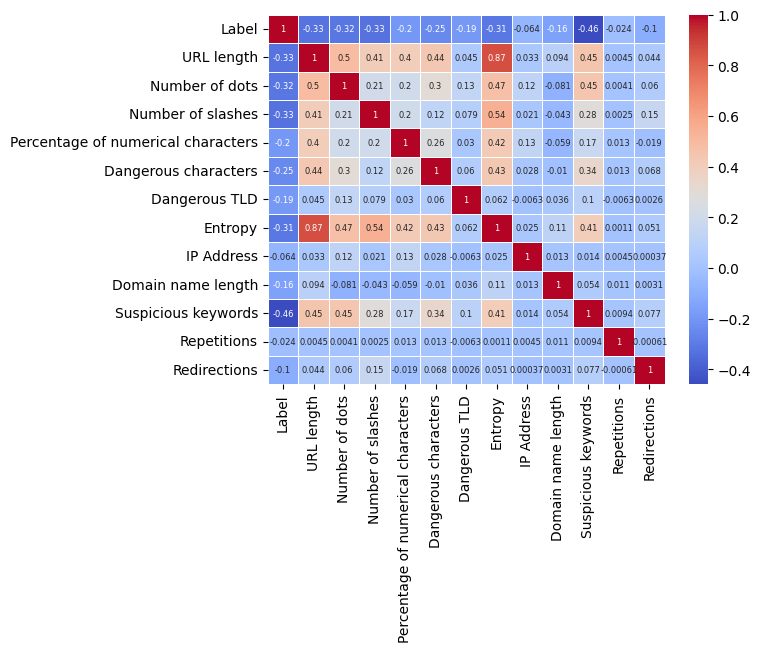

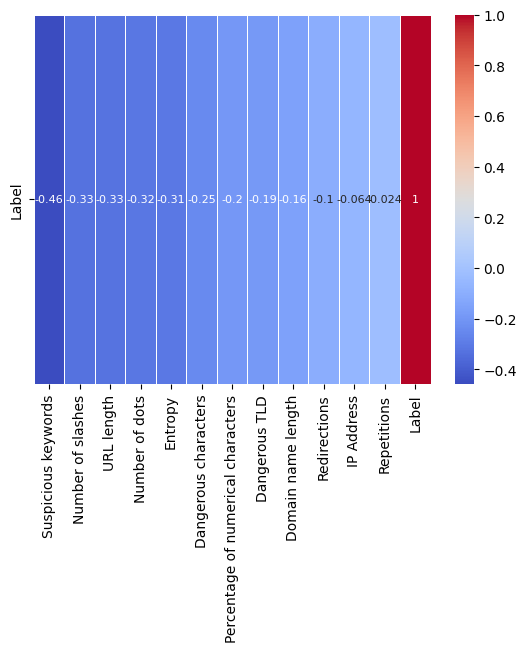

                                       Label
Suspicious keywords                -0.458612
Number of slashes                  -0.332658
URL length                         -0.325594
Number of dots                     -0.315512
Entropy                            -0.309497
Dangerous characters               -0.245217
Percentage of numerical characters -0.196412
Dangerous TLD                      -0.190754
Domain name length                 -0.155433
Redirections                       -0.104069
IP Address                         -0.063543
Repetitions                        -0.024118
Label                               1.000000


In [ ]:
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 6})
plt.show()
sns.heatmap(corr_matrix[['Label']].sort_values(by='Label').T, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
plt.show()
print(corr_matrix[['Label']].sort_values(by='Label'))

In [ ]:
pca = PCA(n_components=1)
X['Entropy and length (PCA)'] = pca.fit_transform(X[['Entropy', 'URL length']])
X.drop(columns=['Entropy', 'URL length'], inplace=True)

X

,Label,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections,Entropy and length (PCA)
0,0,2.081949,4.256530,0.257778,1,0,0,-0.754153,1,0,0,4.616855
1,0,1.511378,0.762342,0.012346,1,0,0,-0.542810,0,0,0,1.142230
2,0,2.652520,4.838895,0.265537,0,0,0,0.513906,1,0,0,3.556082
3,0,2.081949,-0.402388,0.000000,0,0,0,-0.120124,0,0,0,0.473449
4,0,-0.770906,4.256530,0.181034,1,0,0,1.147935,0,0,1,2.040691
...,...,...,...,...,...,...,...,...,...,...,...,...
321925,1,-0.200335,-0.402388,0.000000,0,0,0,0.513906,0,0,0,-0.168275
321926,1,-0.200335,-0.402388,0.000000,0,0,0,0.513906,0,0,0,-0.558798
321927,1,-0.200335,-0.402388,0.000000,0,0,0,0.513906,0,0,0,-0.363733
321928,1,-0.200335,-0.402388,0.000000,0,0,0,0.513906,0,0,0,-0.012442


In [ ]:
y = X['Label']
X.drop(columns=['Label'], inplace=True)
X

,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections,Entropy and length (PCA)
0,2.081949,4.256530,0.257778,1,0,0,-0.754153,1,0,0,4.616855
1,1.511378,0.762342,0.012346,1,0,0,-0.542810,0,0,0,1.142230
2,2.652520,4.838895,0.265537,0,0,0,0.513906,1,0,0,3.556082
3,2.081949,-0.402388,0.000000,0,0,0,-0.120124,0,0,0,0.473449
4,-0.770906,4.256530,0.181034,1,0,0,1.147935,0,0,1,2.040691
...,...,...,...,...,...,...,...,...,...,...,...
321925,-0.200335,-0.402388,0.000000,0,0,0,0.513906,0,0,0,-0.168275
321926,-0.200335,-0.402388,0.000000,0,0,0,0.513906,0,0,0,-0.558798
321927,-0.200335,-0.402388,0.000000,0,0,0,0.513906,0,0,0,-0.363733
321928,-0.200335,-0.402388,0.000000,0,0,0,0.513906,0,0,0,-0.012442


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
kf = KFold(n_splits=3, shuffle=True, random_state=22)


In [ ]:
xgb_model = XGBClassifier(random_state=22)
rf_model = RandomForestClassifier(random_state=22)
knn_model = KNeighborsClassifier()
logreg_model = LogisticRegression(random_state=22)

In [ ]:
# Cross-validation scores
print("Cross-validation scores:")
print("XGB:", cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring='accuracy').mean())
print("RF:", cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='accuracy').mean())
print("KNN:", cross_val_score(knn_model, X_train, y_train, cv=kf, scoring='accuracy').mean())
print("LogReg:", cross_val_score(logreg_model, X_train, y_train, cv=kf, scoring='accuracy').mean())

Cross-validation scores:
XGB: 0.8883414096232101
RF: 0.8842256080514398
KNN: 0.8808708414872798
LogReg: 0.8298620818190289


In [ ]:
# Training models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=22)

In [ ]:
# Predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
knn_pred = knn_model.predict(X_test)
logreg_pred = logreg_model.predict(X_test)

In [ ]:
# Metrics
models = {
    "Random Forest": rf_pred,
    "XGBoost": xgb_pred,
    "KNN": knn_pred,
    "Logistic Regression": logreg_pred
}

In [ ]:
print("\nModel Performance Metrics:")
for model_name, predictions in models.items():
    print(f"\n{model_name}:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Precision:", precision_score(y_test, predictions))
    print("Recall:", recall_score(y_test, predictions))
    print("F1 Score:", f1_score(y_test, predictions))


Model Performance Metrics:

Random Forest:
Accuracy: 0.8885161370484267
Precision: 0.9170232241309577
Recall: 0.9292478267434586
F1 Score: 0.9230950544270163

XGBoost:
Accuracy: 0.8879259466343615
Precision: 0.8947856782652547
Recall: 0.9568584309411333
F1 Score: 0.9247816206975629

KNN:
Accuracy: 0.8861398440654801
Precision: 0.9058821082407754
Recall: 0.9394723786104101
F1 Score: 0.9223715281086862

Logistic Regression:
Accuracy: 0.8299785667691735
Precision: 0.8252148997134671
Recall: 0.9691322073383809
F1 Score: 0.8914020416059046


In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 400)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 0.3)
    subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-3, 10.0)

    model = XGBClassifier(
        random_state=22,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        reg_alpha=reg_alpha
    )
    return cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
best_xgb_model = XGBClassifier(**best_params, random_state=22)
best_xgb_model.fit(X_train, y_train)

# Print the best accuracy
print("Best accuracy achieved during hyperparameter tuning:", study.best_value)


[I 2024-12-06 05:59:40,158] A new study created in memory with name: no-name-e883ed90-39fc-4b5a-8b84-882fb27291b4
[I 2024-12-06 05:59:55,502] Trial 0 finished with value: 0.8665975522629142 and parameters: {'n_estimators': 339, 'max_depth': 4, 'learning_rate': 0.020187493430903463, 'subsample': 0.7671867070841041, 'reg_alpha': 0.11713888016551785}. Best is trial 0 with value: 0.8665975522629142.
[I 2024-12-06 06:00:00,736] Trial 1 finished with value: 0.7815518901624577 and parameters: {'n_estimators': 111, 'max_depth': 6, 'learning_rate': 0.0034264624163294196, 'subsample': 0.6169240032098845, 'reg_alpha': 6.551769400322591}. Best is trial 0 with value: 0.8665975522629142.
[I 2024-12-06 06:00:08,630] Trial 2 finished with value: 0.7179316932252352 and parameters: {'n_estimators': 132, 'max_depth': 5, 'learning_rate': 0.001975160454835729, 'subsample': 0.7616682637021837, 'reg_alpha': 1.9113781420976803}. Best is trial 0 with value: 0.8665975522629142.
[I 2024-12-06 06:00:15,756] Trial

Best accuracy achieved during hyperparameter tuning: 0.8867378001428882


In [ ]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=200,  # Number of trees
    max_depth=10,      # Maximum depth of trees
    random_state=22    # Seed for reproducibility
)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest on the test set
y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

print("Random Forest Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")


Random Forest Performance:
Accuracy: 0.8644
Precision: 0.8533
Recall: 0.9800
F1 Score: 0.9123


In [ ]:
def classify_url_with_rf(url, model, dangerous_chars, dangerous_TLDs, scaler, pca):
    data = {
        'URL length': len(url),
        'Number of dots': url.count('.'),
        'Number of slashes': url.count('/'),
        'Percentage of numerical characters': sum(c.isdigit() for c in url) / len(url),
        'Dangerous characters': any(char in url for char in dangerous_chars),
        'Dangerous TLD': tldextract.extract(url).suffix in dangerous_TLDs,
        'Entropy': urlentropy(url),
        'IP Address': bool(re.search(ip_pattern, url)),
        'Domain name length': len(tldextract.extract(url).domain),
        'Suspicious keywords': sum(word in url for word in sus_words),
        'Repetitions': bool(re.search(r'(.)\1{2,}', tldextract.extract(url).domain)),
        'Redirections': url.rfind('//') > 7
    }
    num_features = ['URL length', 'Number of dots', 'Number of slashes', 'Domain name length', 'Entropy']
    scaled_features = scaler.transform([[data[feature] for feature in num_features]])
    for i, feature in enumerate(num_features):
        data[feature] = scaled_features[0][i]

    data['Entropy and length (PCA)'] = pca.transform([[data['Entropy'], data['URL length']]])[0][0]
    data.pop('Entropy')
    data.pop('URL length')

    input_df = pd.DataFrame([data])
    prediction = model.predict(input_df)
    return "Safe" if prediction[0] == 1 else "Not Safe"

# Example usage with Random Forest model
user_url = input("Enter a URL to check: ")
print("URL Status:", classify_url_with_rf(user_url, rf_model, dangerous_chars, dangerous_TLDs, scaler, pca))

Enter a URL to check: https://www.youtube.com/
URL Status: Safe
